# Ship recognition on satellite images - Evaluation and visualization notebook
Team members: 
* Csatlós Tamás Péter (cstompet@gmail.com)
* Kalapos András (kalapos.andras@gmail.com)

## Import libraries, functions, load test data and the trained network

In [1]:
##################################################################################
# Imports
##################################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from tqdm import tqdm, tqdm_notebook
import imageio
import cv2

from keras.models import load_model
from keras import backend as K

import keras.models as models
from keras.models import Model

##################################################################################
# Import Function definitions
##################################################################################
from ShipSegFunctions import *

Using TensorFlow backend.


In [2]:
##################################################################################
# GPU info
##################################################################################
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto(device_count = {'GPU': 0}) # Use CPU for the testing
config = tf.ConfigProto() # Use GPU
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
# print(device_lib.list_local_devices())
# print(K.tensorflow_backend._get_available_gpus())


In [6]:
##################################################################################
# PARAMETERS
##################################################################################
# Data on AWS
image_path = "/data/train_v2"
segmentation_data_file_path = '/data/train_ship_segmentations_v2.csv'
model_path = ""
# Data locally
# image_path = "/run/media/kalap/Storage/Deep learning 2/train_v2"
# segmentation_data_file_path = '/run/media/kalap/Storage/Deep learning 2/train_ship_segmentations_v2.csv'
# Data on Github
# image_path = "../data/train_img"
# segmentation_data_file_path = '../data/train_ship_segmentations_v2.csv'

resize_img_to = (768, 768)
# resize_img_to = (384, 384)
# resize_img_to = (256, 256)
# resize_img_to = (192, 192)
batch_size = 4

In [7]:
##################################################################################
# Load and prepare the data
##################################################################################

# Load the file which contains the masks for each image
df_train = pd.read_csv(segmentation_data_file_path)

# Load the test data ids saved by the Train file
test_img_ids = np.load(model_path + "test_img_ids.npy")

##################################################################################
# Load the network
##################################################################################
model = load_model(model_path + "model.hdf5", custom_objects={'dice_coef_loss': dice_coef_loss})
# print(model.summary())

##################################################################################
# Define data generator
##################################################################################

test_generator = DataGenerator(
    test_img_ids,
    df_train,
    image_path,
    batch_size=batch_size,
    dim=resize_img_to,
    shuffle_on_every_epoch=False,
    shuffle_on_init=False,
    split_to_sub_img=False,
    drop_duplicates=True
)

## Predict segmentation for test images

In [11]:
test_ratio = 0.01 # We choose the test partition too large, so we'll only use a smaller part of it

# Generate the first batch of images to initialize the variables
tmp_images, tmp_masks_true = test_generator.__getitem__(0)
tmp_ids = test_generator.get_last_batch_ImageIDs()
# Generate the predictions for the first batch
predictions_tmp = model.predict(tmp_images, verbose=1)

# Initialize the variables storing the test data
test_images = tmp_images
test_ids = tmp_ids
test_mask_true = tmp_masks_true
predictions = predictions_tmp

test_ratio = 0.01
for i in tqdm(range(1,int(test_ratio * len(test_img_ids)/batch_size)+1)):
    # Generate test images
    tmp_images, tmp_masks_true = test_generator.__getitem__(i)
    tmp_ids = test_generator.get_last_batch_ImageIDs()
    
    # Generate test predictions
    predictions_tmp = model.predict(tmp_images, verbose=0)
    
    # Store everything
    test_images = np.concatenate((test_images, tmp_images), axis=0)
    test_ids = np.concatenate((test_ids,tmp_ids),axis=0)
    test_mask_true = np.concatenate((test_mask_true, tmp_masks_true), axis=0)
    predictions = np.concatenate((predictions, predictions_tmp), axis=0)    

4/4 [==============================] - 2s 530ms/step


100%|██████████| 30/30 [01:35<00:00,  3.91s/it]


## Display and save test images and segmentation maps

(124, 768, 768, 1)


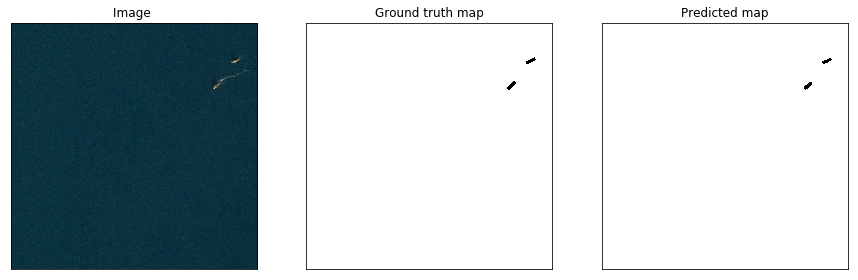

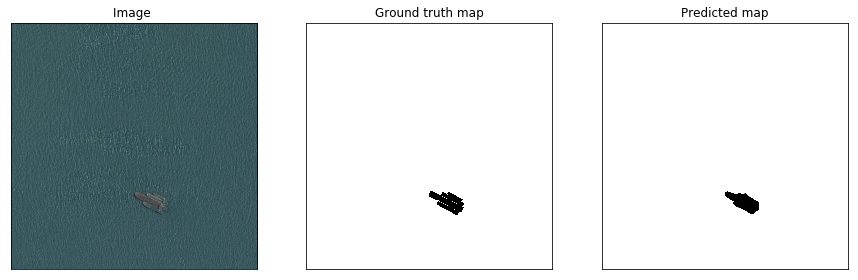

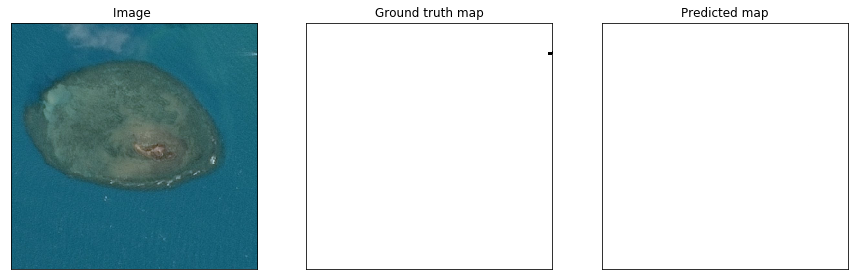

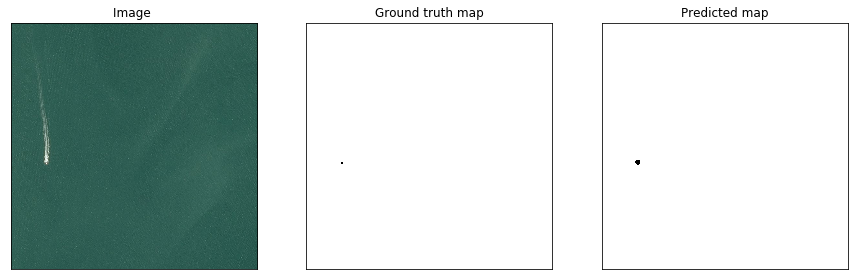

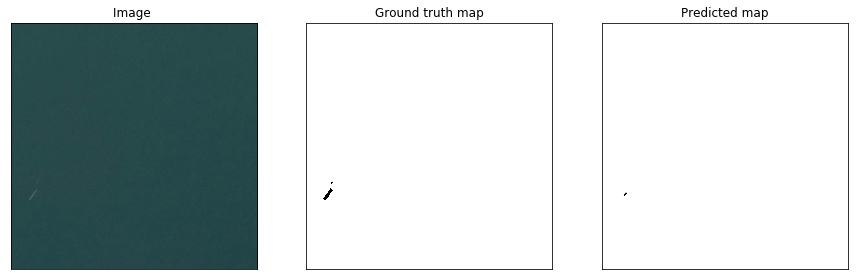

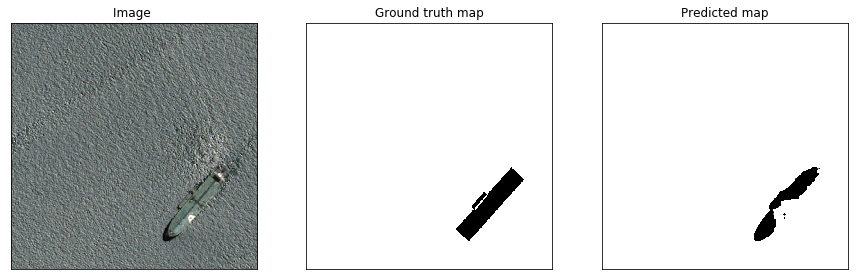

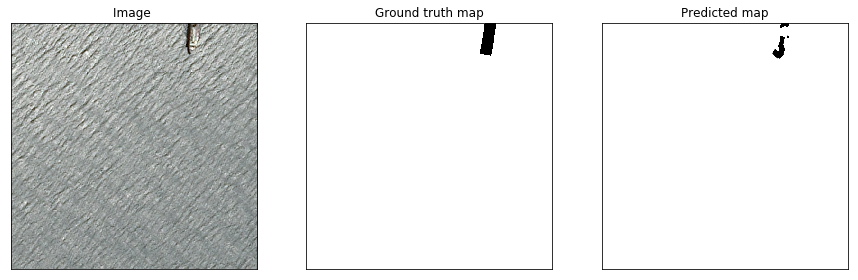

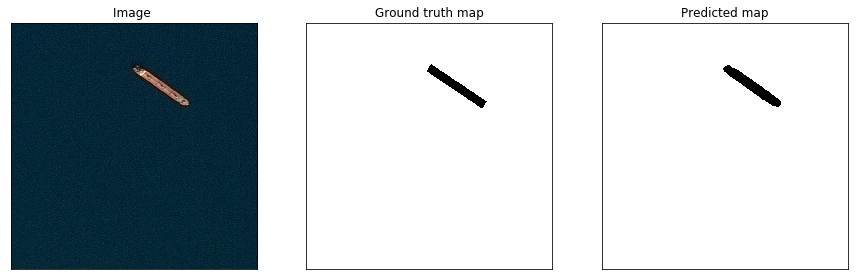

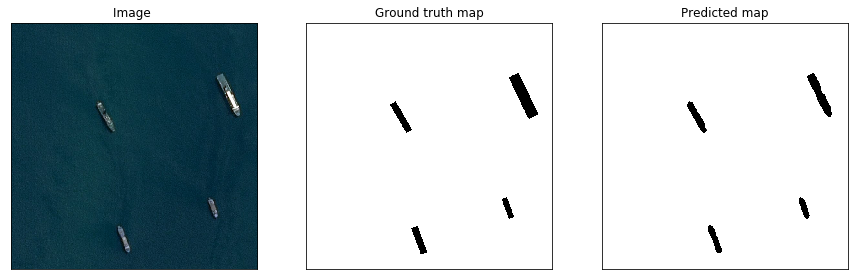

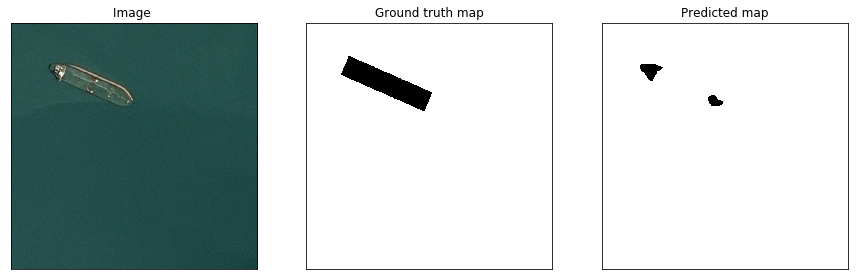

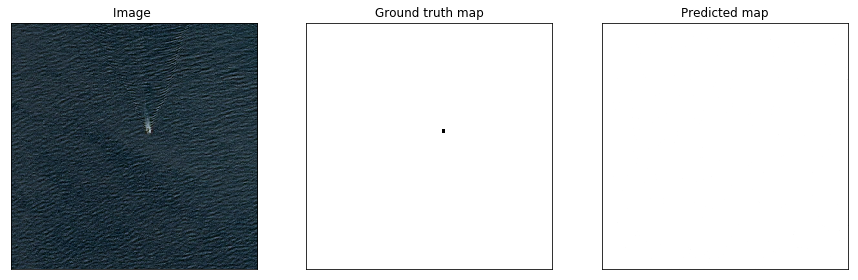

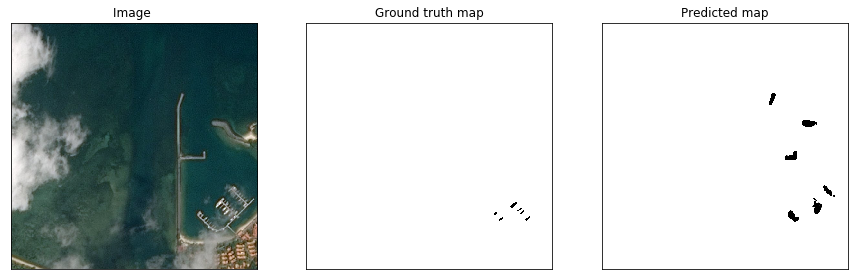

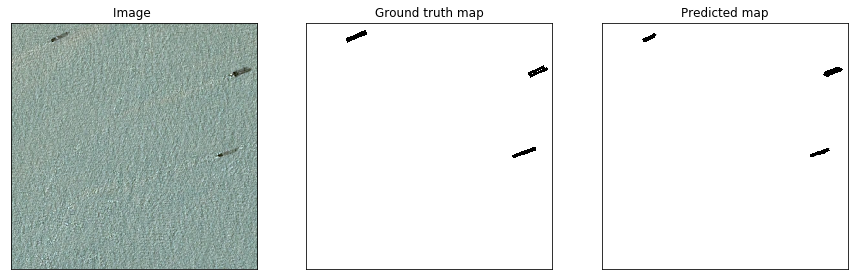

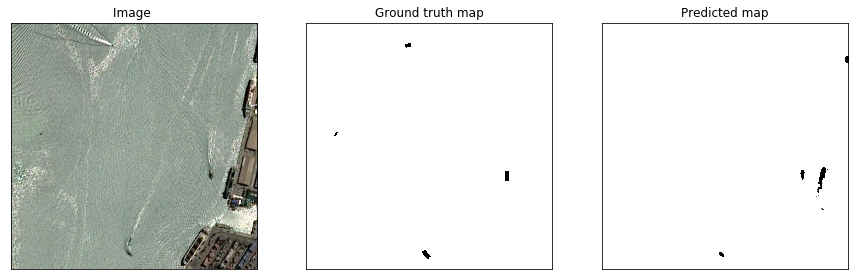

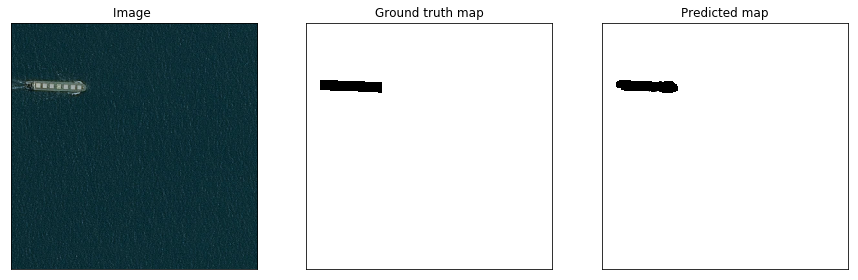

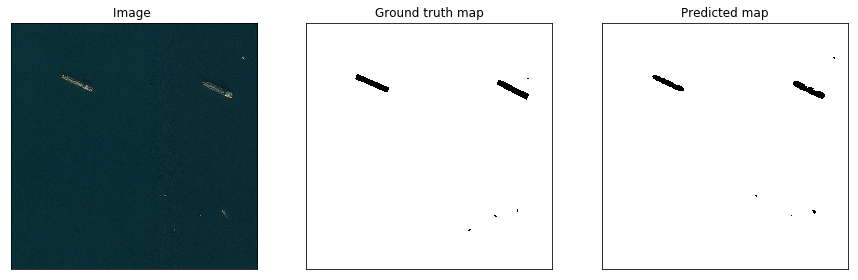

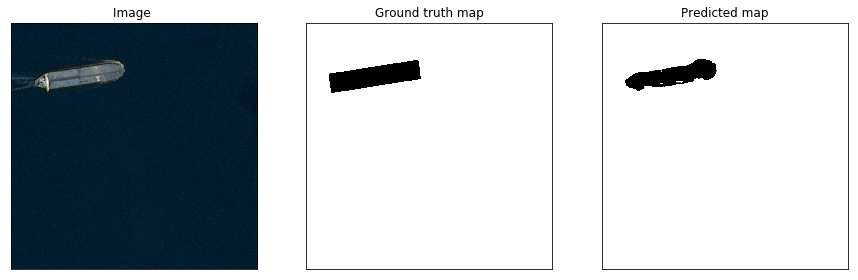

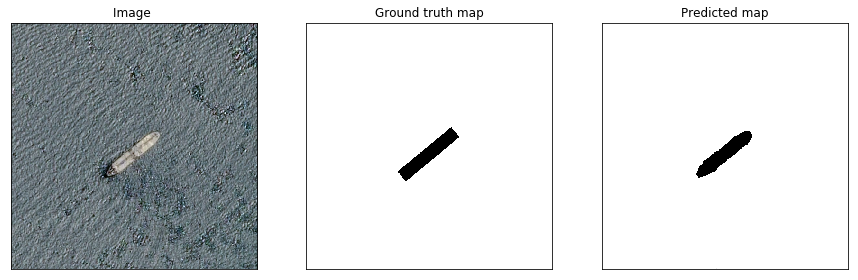

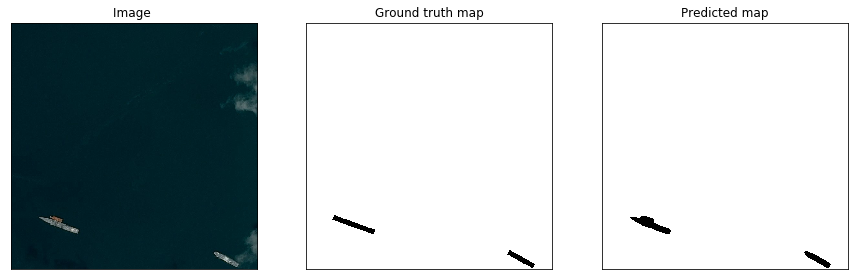

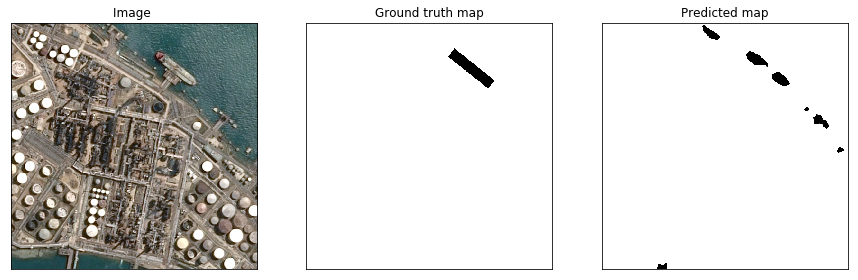

In [12]:
print(predictions.shape)
for i in range(20):
    disp_image_with_map2(test_images[i], test_mask_true[i], predictions[i])
    plt.imsave("Img/" + test_ids[i],test_images[i] * 0.5 + 0.5)
    plt.imsave("Img/" + test_ids[i] + "_true.jpg",test_mask_true[i,:, :, 0], cmap='Greys')
    plt.imsave("Img/" + test_ids[i] + "_pred.jpg",predictions[i,:, :, 0], cmap='Greys')

## Confusion matrix

Normalized confusion matrix
[[ 0.99874789  0.00125211]
 [ 0.3510743   0.6489257 ]]


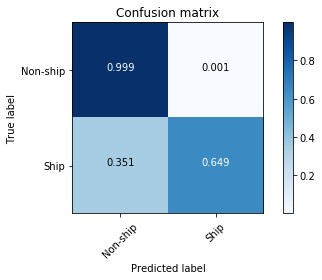

In [13]:
from sklearn.metrics import confusion_matrix
threshold = 0.5
predictions = (predictions>threshold).astype(int)

conf = confusion_matrix(test_mask_true.flatten(),predictions.flatten());
plot_confusion_matrix(conf,classes=["Non-ship", "Ship"], normalize=True);
plt.show()

## Test scores

In [14]:
from sklearn.metrics import jaccard_similarity_score, f1_score, balanced_accuracy_score
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(np.multiply(y_true_f,y_pred_f))
    return (2.0 * intersection + 1.0) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1.0)

jaccard = jaccard_similarity_score(test_mask_true.flatten(),predictions.flatten())
balanced = balanced_accuracy_score(test_mask_true.flatten(),predictions.flatten())
f1 = f1_score(test_mask_true.flatten(),predictions.flatten())
dice = dice_coef_np(test_mask_true,predictions)
print("Jaccard similarity score: ", jaccard)
print("Balanced accuracy score:", balanced)
print("F1 similarity score: ", f1)
print("Dice coefficient", dice)

Jaccard similarity score:  0.996716338674
Balanced accuracy score: 0.823836796887
F1 similarity score:  0.696541502351
Dice coefficient 0.696541885789
